In [1]:
import pandas as pd
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

from evaluation import get_cm_sklearn, print_metrics
from preprocessing import TrainingPreProcessor

RANDOM_STATE = 0

train_set = pd.read_csv("input/train.csv")

training_preprocessor = TrainingPreProcessor()
training_preprocessor.fit(train_set, ignore_columns=["CLIENTNUM"])

X, y = training_preprocessor.transform(train_set)
class_weight = training_preprocessor.class_weight

## Recuperação dos melhores modelos encontrados por gridsearch

In [2]:
logistic_regression_model = LogisticRegression(
    random_state=RANDOM_STATE,
    class_weight=class_weight,
    solver="saga",
    **{"C": 0.1, "max_iter": 1000, "penalty": "l2", "tol": 0.0001}
)

svc_model = SVC(
    random_state=RANDOM_STATE,
    class_weight=class_weight,
    **{"C": 1.0, "kernel": "rbf", "max_iter": 10000, "tol": 0.001}
)

rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight=class_weight,
    **{
        "criterion": "entropy",
        "max_depth": 7,
        "max_features": "sqrt",
        "n_estimators": 50,
    }
)

kfold = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)

test_set = pd.read_csv("input/test.csv")
X_test, y_test = training_preprocessor.transform(test_set)

## Treinando e avaliando um ensemle de votação

In [3]:
voting_ensemble = VotingClassifier(
    estimators=[
        ("logistic_regression", logistic_regression_model),
        ("svc", svc_model),
        ("random_forest", rf_model),
    ],
    voting="hard",
)
voting_ensemble.fit(X, y)

VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(C=0.1,
                                                 class_weight={0: 3.1157692307692306,
                                                               1: 0.5955741802676077},
                                                 max_iter=1000, random_state=0,
                                                 solver='saga')),
                             ('svc',
                              SVC(class_weight={0: 3.1157692307692306,
                                                1: 0.5955741802676077},
                                  max_iter=10000, random_state=0)),
                             ('random_forest',
                              RandomForestClassifier(class_weight={0: 3.1157692307692306,
                                                                   1: 0.5955741802676077},
                                                     criterion='entropy',
                                                     max_depth=7,
                                                     n_estimators=50,
                                                     random_state=0))])

Accuracy: 0.9215202369200395
Balanced Accuracy: 0.916164932421122
F1: 0.9518035768414672
RoC AuC: 0.916164932421122


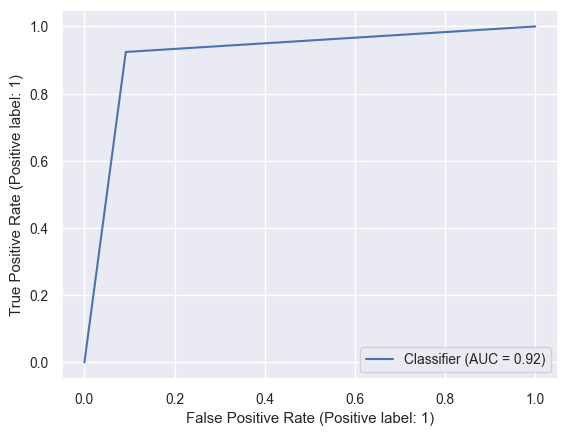

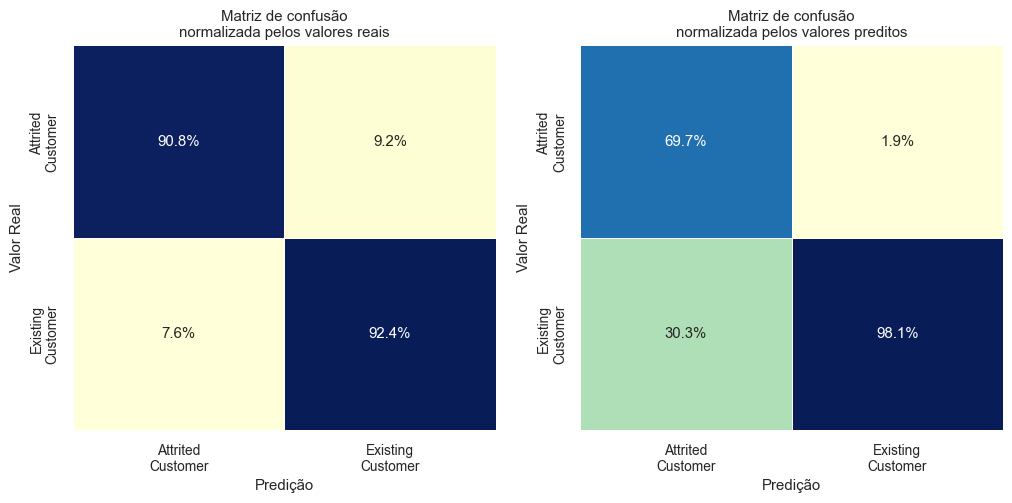

In [7]:
y_pred_test_voting = voting_ensemble.predict(X_test)

print_metrics(y_test, y_pred_test_voting)

get_cm_sklearn(
    y_test,
    y_pred_test_voting,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)

## Treinando e avaliando (sobre validação) um ensemle de empilhamento

In [9]:
stacking_ensemble = StackingClassifier(
    estimators=[
        ("logistic_regression", logistic_regression_model),
        ("svc", svc_model),
        ("random_forest", rf_model),
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=kfold,
)
stacking_ensemble.fit(X, y)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimators=[('logistic_regression',
                                LogisticRegression(C=0.1,
                                                   class_weight={0: 3.1157692307692306,
                                                                 1: 0.5955741802676077},
                                                   max_iter=1000,
                                                   random_state=0,
                                                   solver='saga')),
                               ('svc',
                                SVC(class_weight={0: 3.1157692307692306,
                                                  1: 0.5955741802676077},
                                    max_iter=10000, random_state=0)),
                               ('random_forest',
                                RandomForestClassifier(class_weight={0: 3.1157692307692306,
                                                                     1: 0.5955741802676077},
                                                       criterion='entropy',
                                                       max_depth=7,
                                                       n_estimators=50,
                                                       random_state=0))],
                   final_estimator=LogisticRegression(random_state=0))

Accuracy: 0.9417571569595261
Balanced Accuracy: 0.8763708819543066
F1: 0.9655373831775701
RoC AuC: 0.8763708819543066


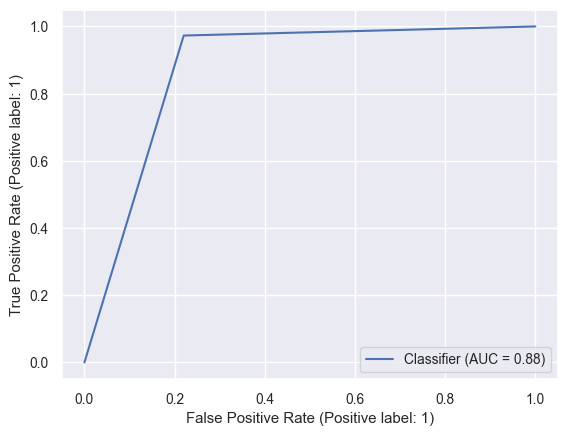

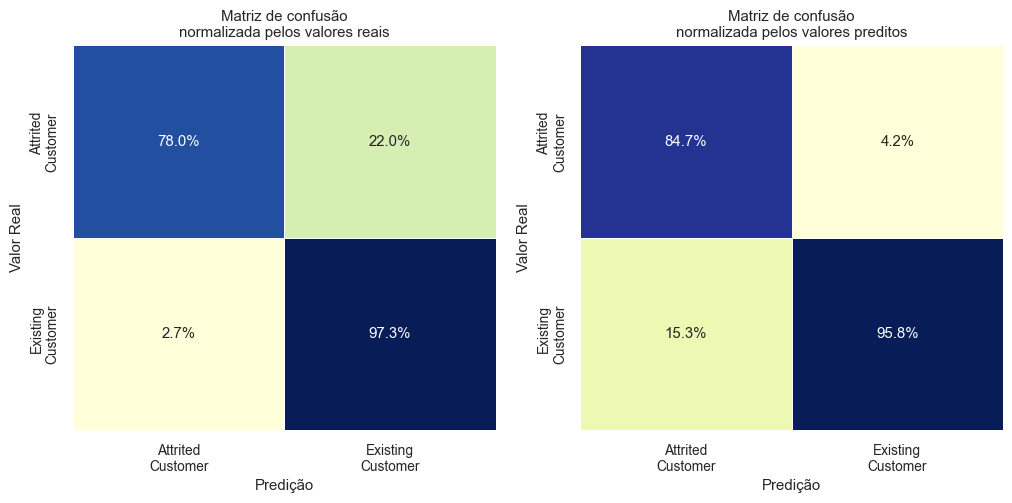

In [10]:
y_pred_test_stacking = stacking_ensemble.predict(X_test)

print_metrics(y_test, y_pred_test_stacking)

get_cm_sklearn(
    y_test,
    y_pred_test_stacking,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)